In [1]:
# these lines install modules cleantext and emoji. 
# Module cleantext is used to clean text data including: conversion of texts to lower case, removing unecessary panctuation and removal of stopwords.
# module emoji is needed to remove emocations from text.
!pip install cleantext
!pip install emoji
!pip install wget

  Preparing metadata (setup.py) ... - done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=fc9a5440e75d9b32a6d39c22950f7634d88da915ee62d5eac1ef2063da8d289d
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
# here are all the modules used during this analysis. 
# you can use help() to get documentation of each, eg help('pandas') will give you documentation of pandas

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import cleantext 
import emoji 
import tensorflow as tf
import tensorflow_addons as tfa 
from tensorflow.keras import datasets, layers, models,Input,Model
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, Conv2D, BatchNormalization, MaxPooling2D, Flatten, LSTM, Dense, Lambda, Dropout,Reshape,GlobalAveragePooling1D
import re
import keras
import shutil
import string
import random
import requests
from sklearn.cluster import KMeans
from sklearn import metrics
import wget
import zipfile
import os
from sklearn.metrics import (confusion_matrix,accuracy_score)
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import GridSearchCV
from functools import reduce
from sklearn.tree import DecisionTreeClassifier as DR
from sklearn.ensemble import GradientBoostingClassifier as GBoost

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator
import pickle
from sklearn.decomposition import PCA
# call backs
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=20)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
2022-12-07 12:45:02.213223: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-07 12:45:02.213392: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-07 12:45:02.214662: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [3]:
with open("/kaggle/input/fakerealmainoutputdata/kmea.pkl","rb") as file:
    kmea=pickle.load(file)
    
with open("/kaggle/input/fakerealmainoutputdata/predictors.pkl","rb") as file:
    predictors=pickle.load(file)
    
with open("/kaggle/input/fakerealmainoutputdata/tests.pkl","rb") as file:
    tests=pickle.load(file)
    
test=tf.data.experimental.load("/kaggle/input/fakerealmainoutputdata/train")
train=tf.data.experimental.load("/kaggle/input/missingtest/train")
valid=tf.data.experimental.load("/kaggle/input/fakerealmainoutputdata/valid")
model = keras.models.load_model('/kaggle/input/fakerealmainoutputdata/model')

2022-12-07 12:45:02.325767: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
# some parameters to be used
# some of this were relevantduring code creation
batch_size=64  #  Batch sizes to use
epoch =200       # number of training ephochs
sequence_length = 250   # here we can set arguments for text vectorization      
max_tokens=20000

vectorize_layer = layers.TextVectorization(
    max_tokens=max_tokens,
    pad_to_max_tokens=True,
    output_mode='int')

train_article = train.map(lambda x, y: x)
vectorize_layer.adapt(train_article)


def vectorize_articles(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

AUTOTUNE = tf.data.AUTOTUNE 
train = train.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)  # set catching and prefetching on training data
valid = valid.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)  #set catching and prefetching on testing data
test = test.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)    #  set catching and prefetching on validation data

2022-12-07 12:45:22.124931: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


# Baseline methods
 
**_The proposed approach will be compared to currently existing classifiers including decision trees, K nearest neighbor algorithm, SVM, and boosted classification tree, regarding the time complexity and classification accuracy.  Two types of feature extraction methods will be considered, features extracted using Convolution neural networks and TF-IDF features. _**

In [5]:
def labels(ds):
    labels=[]
    for batch in ds:
        articles,labelss=batch
        labelss=labelss.numpy()
        labels.append(labelss)
    labels=np.concatenate(labels)
    return labels

label_train=np.argmax(labels(train),axis=1)
label_test=np.argmax(labels(test),axis=1)
label_valid=np.argmax(labels(valid),axis=1)

In [6]:
feature_miner=Model(
    inputs=model.inputs,
    outputs=model.get_layer(name="Bidirectional2").output,name="feature_miner"
)

In [7]:
feature_miner.summary()

Model: "feature_miner"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_articles (InputLayer)  [(None, None)]            0         
_________________________________________________________________
embeddinglayer (Embedding)   (None, None, 100)         2000100   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 8)           4008      
_________________________________________________________________
dropout1 (Dropout)           (None, None, 8)           0         
_________________________________________________________________
batchnormalization (BatchNor (None, None, 8)           32        
_________________________________________________________________
Bidirectional2 (Bidirectiona (None, 16)              

In [8]:
X_train=predictors
y_train=label_train
X_test=tests
y_test=label_test
X_valid=feature_miner.predict(valid)
y_valid=label_valid

# Boosted Decision trees 
 **_The process of boosting involves combining multiple weak learners to give improved predictive performance (Elith et al., 2008). In decision trees, it involves fitting new decision trees giving more weight to the misclassifications of the previous subsequent tree (Natekin & Knoll, 2013) this is repeated until the tree performance can’t be improved further._**
 
 Similar to the other models. the model will be fit while tuning hyper parameters to achieve high performance

In [9]:
gbr_params = {'n_estimators': 1000,
          'max_depth': 3,
          'min_samples_split': 5,
          'learning_rate': 0.01}
np.random.seed(10)
boosted = GBoost(**gbr_params,verbose=1)
boosted =boosted.fit(X_train,y_train)

      Iter       Train Loss   Remaining Time 
         1           0.7031           34.28s
         2           0.6899           33.67s
         3           0.6775           33.45s
         4           0.6659           33.15s
         5           0.6548           33.16s
         6           0.6444           33.12s
         7           0.6343           33.37s
         8           0.6248           33.31s
         9           0.6157           33.15s
        10           0.6070           33.05s
        20           0.5356           32.77s
        30           0.4827           32.76s
        40           0.4412           32.16s
        50           0.4073           31.71s
        60           0.3787           31.26s
        70           0.3547           30.86s
        80           0.3343           30.47s
        90           0.3166           30.09s
       100           0.3009           29.72s
       200           0.2165           26.16s
       300           0.1863           22.81s
       40

In [10]:
parameters = {'n_estimators': [1000],
              "max_depth" : [5,10,15,20],
              'min_samples_split': [5,6,7,8,10],
              'learning_rate': [0.01,0.02,0.03]}

In [11]:
tuning_model=GridSearchCV(boosted,param_grid=parameters,cv=3,n_jobs=-1)
tuning_model.fit(X_train,y_train)
tuning_model.best_params_

      Iter       Train Loss   Remaining Time 
         1           0.7019           50.14s
         2           0.6877           50.17s
         3           0.6744           50.35s
         4           0.6618           50.14s
         5           0.6500           50.03s
         6           0.6387           49.99s
         7           0.6281           49.93s
         8           0.6179           49.85s
         9           0.6082           49.84s
        10           0.5989           49.82s
        20           0.5225           49.30s
        30           0.4660           48.63s
        40           0.4215           48.02s
        50           0.3850           47.54s
        60           0.3546           47.12s
        70           0.3289           46.60s
        80           0.3068           46.30s
        90           0.2878           45.81s
       100           0.2709           45.27s
       200           0.1757           40.53s
       300           0.1393           35.37s
       40

{'learning_rate': 0.03,
 'max_depth': 10,
 'min_samples_split': 6,
 'n_estimators': 1000}

In [12]:
boosted = GBoost(**tuning_model.best_params_)
boosted =boosted.fit(X_train,y_train)


       100           0.0310            2.23m
       200           0.0041            1.95m
       300           0.0016            1.72m
       400           0.0012            1.47m
       500           0.0010            1.22m
       600           0.0010           58.62s
       700           0.0010           43.88s
       800           0.0010           29.25s
       900           0.0010           14.52s
      1000           0.0010            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.6602            1.76m
         2           0.6143            1.76m
         3           0.5758            1.77m
         4           0.5426            1.80m
         5           0.5134            1.77m
         6           0.4872            1.76m
         7           0.4636            1.74m
         8           0.4419            1.73m
         9           0.4220            1.74m
        10           0.4036            1.73m
        20           0.2709            1.78m
        

In [13]:
tuning_model.best_params_

{'learning_rate': 0.03,
 'max_depth': 10,
 'min_samples_split': 6,
 'n_estimators': 1000}

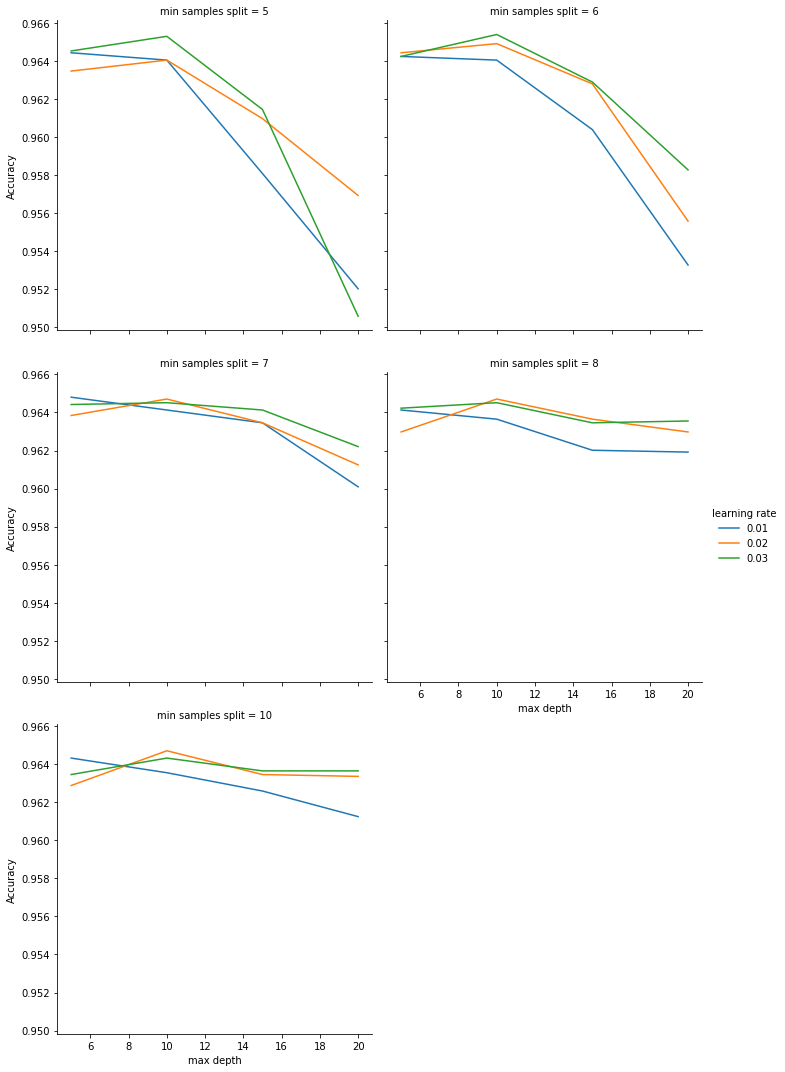

In [14]:
dat=pd.DataFrame(tuning_model.cv_results_)
dat.rename(columns = {'mean_test_score':'Accuracy','param_min_samples_split':'min samples split',
                     'param_learning_rate':'learning rate','param_max_depth':'max depth'}, inplace = True)
g = sns.FacetGrid(dat,
                  height=5, col='min samples split',
                  hue='learning rate',col_wrap=2)
g.map_dataframe(sns.lineplot,x='max depth',y='Accuracy')
g.add_legend()
plt.savefig('boosted.png')

In [15]:
model=boosted.fit(X_train,y_train)


       900           0.0008           16.28s
      1000           0.0008            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.6627            2.22m
         2           0.6189            2.14m
         3           0.5820            2.12m
         4           0.5500            2.13m
         5           0.5218            2.13m
         6           0.4962            2.14m
         7           0.4731            2.14m
         8           0.4520            2.15m
         9           0.4324            2.15m
        10           0.4145            2.16m
        20           0.2833            2.43m
        30           0.2020            2.60m
        40           0.1473            2.67m
        50           0.1086            2.72m
        60           0.0809            2.74m
        70           0.0610            2.73m
        80           0.0461            2.76m
        90           0.0350            2.74m
       100           0.0267            2.72m
       2

In [16]:
predictions=np.round(model.predict(X_test))
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             'boosted':[metrics.accuracy_score(y_test,predictions),
                        metrics.recall_score(y_test, predictions,pos_label=0),
                        metrics.recall_score(y_test, predictions,pos_label=1),
                        metrics.precision_score(y_test,predictions,pos_label=0),
                        metrics.f1_score(y_test,predictions,pos_label=0)]})

,Measure,boosted
0,Accuracy,0.906154
1,Sensitivity,0.473913
2,Specitivity,0.963953
3,Precision,0.637427
4,F1_score,0.543641


In [17]:
with open("tuning_model.pkl","wb") as file:
    pickle.dump(tuning_model,file)
    
with open("boosted.pkl","wb") as file:
    pickle.dump(model,file)

In [18]:

predictions=np.round(model.predict(X_valid))
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             'boosted':[metrics.accuracy_score(y_valid,predictions),
                        metrics.recall_score(y_valid, predictions,pos_label=0),
                        metrics.recall_score(y_valid, predictions,pos_label=1),
                        metrics.precision_score(y_valid,predictions,pos_label=0),
                        metrics.f1_score(y_valid,predictions,pos_label=0)]})

,Measure,boosted
0,Accuracy,0.903077
1,Sensitivity,0.486111
2,Specitivity,0.955017
3,Precision,0.573770
4,F1_score,0.526316
